# Looking into data science and machine learning Tools in SKlearn


# 1 General Model overviews

### 1.1 Regression

### 1.2 Classification

# 2 More nuance sklearn features

<br>

In [1]:
import numpy as np
import pandas as pd
import eli5
import matplotlib.pyplot as plt
import random
from random import randrange

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import r2_score
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

## 1.1 Regression
#### Random forest + GridSearch + prerprocessor

In [2]:
boston = datasets.load_boston()
y = boston.target
x = boston.data

In [3]:
df = pd.DataFrame(x, columns = boston.feature_names)
df['y'] = y

# Adding a random categorica column just for learning
data = ["paris", "barcelona", "kolkata", "new york"]

df['location'] = [random.sample(data,1)[0] for x in range(len(df))]

#adding nulls
for i in range(int(len(df)*0.2)):
    df['RM'][randrange(len(df))] = np.nan
    df['AGE'][randrange(len(df))] = np.nan
    df['TAX'][randrange(len(df))] = np.nan
    
df.isnull().sum() * 100 / len(df)

df.head(10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


CRIM    ZN  INDUS  CHAS    NOX     RM    AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575   65.2  4.0900  1.0    NaN   
1  0.02731   0.0   7.07   0.0  0.469  6.421    NaN  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185   61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998   45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458    NaN   54.2  6.0622  3.0    NaN   
5  0.02985   0.0   2.18   0.0  0.458  6.430   58.7  6.0622  3.0    NaN   
6  0.08829  12.5   7.87   0.0  0.524  6.012   66.6  5.5605  5.0  311.0   
7  0.14455  12.5   7.87   0.0  0.524  6.172   96.1  5.9505  5.0  311.0   
8  0.21124  12.5   7.87   0.0  0.524    NaN  100.0  6.0821  5.0  311.0   
9  0.17004  12.5   7.87   0.0  0.524  6.004   85.9  6.5921  5.0    NaN   

   PTRATIO       B  LSTAT     y   location  
0     15.3  396.90   4.98  24.0  barcelona  
1     17.8  396.90   9.14  21.6    kolkata  
2     17.8  392.83   4.03  34.7      paris  
3     18.7  394.63   2.94  33.4      paris  
4     18.7  396.90   5.33  36.2    kolkata  
5     18.7  394.12   5.21  28.7  barcelona  
6     15.2  395.60  12.43  22.9   new york  
7     15.2  396.90  19.15  27.1  barcelona  
8     15.2  386.63  29.93  16.5      paris  
9     15.2  386.71  17.10  18.9   new york

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('y', axis = 1), df['y'], test_size = 0.3, shuffle = True, \
                                                   random_state = 42)

#### Split data and create lists

In [5]:
numeric_vars = X_train.select_dtypes(include = np.number).columns.to_list()
categorical_vars = X_train.select_dtypes(exclude = np.number).columns.to_list()
skewed_vars = ['NOX']

print("Numerical cols: ",numeric_vars)
print("categorical cols: ",categorical_vars)

Numerical cols:  ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
categorical cols:  ['location']


#### Pipeline

Like In a real project I only do the simple preprocessing in the Sklearn pipeline, the more complex stuff will be done prior to this.

E.g we presume when the data is split all engineering is completed

In [6]:
# Pipeline for skewed variables
skew_transformer = PowerTransformer()
skewed_features = []
# Pipeline for numerical variables
numeric_transformer = Pipeline(
    steps=[ 
        ("scaler", StandardScaler()), 
        ("num_imputer",IterativeImputer(max_iter=10, random_state=0))
        #("Pca", PCA())
          ])

# Pipeline for categorical variables
categorical_transformer = Pipeline(
    steps= [ 
        ("categorical_vars", OneHotEncoder(sparse = False, handle_unknown = "ignore")), 
        ("cat_imputer", SimpleImputer(strategy="median"))
           ])

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("skew", skew_transformer, skewed_features),
        ("num", numeric_transformer, numeric_vars),
        ("cat", categorical_transformer, categorical_vars)
    ]
)

# The model
model = Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestRegressor(n_estimators = 200,  max_depth = 8, random_state = 42)),
    
    
])

In [7]:

param  = [
    {'preprocessor__num__num_imputer__max_iter': [10,20], #Can also tune reprocessor params
    'rf__n_estimators': [100, 150, 200],
    'rf__max_features': ['auto'],
    'rf__criterion': ['squared_error'],
    'rf__max_depth': [3, 5],}
]

In [8]:
grid = GridSearchCV(estimator = model, param_grid = param, cv = 5, verbose = True, n_jobs = -1 )

In [9]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('skew',
                                                                         PowerTransformer(),
                                                                         []),
                                                                        ('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler()),
                                                                                         ('num_imputer',
                                                                                          IterativeImputer(random_state=0))]),
                                                                         ['CRIM',
                                                                      

In [10]:
print("Best Score: %0.5f" % grid.best_score_)
print(grid.best_params_)

Best Score: 0.78243
{'preprocessor__num__num_imputer__max_iter': 10, 'rf__criterion': 'squared_error', 'rf__max_depth': 5, 'rf__max_features': 'auto', 'rf__n_estimators': 200}


In [11]:
model.set_params(**grid.best_params_)
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('skew', PowerTransformer(),
                                                  []),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('num_imputer',
                                                                   IterativeImputer(random_state=0))]),
                                                  ['CRIM', 'ZN', 'INDUS',
                                                   'CHAS', 'NOX', 'RM', 'AGE',
                                                   'DIS', 'RAD', 'TAX',
                                                   'PTRATIO', 'B', 'LSTAT']),
                                                 ('cat',
                                                  Pipeline(steps=[('

In [12]:
y_pred = model.predict(X_test)
model.score(X_test,y_test)

0.8272600241818606

In [13]:
important_features = pd.Series(data=model.named_steps["rf"].feature_importances_,index=np.concatenate((np.asarray(numeric_vars), np.asarray(model['preprocessor'].transformers_[2][1]['categorical_vars'].get_feature_names(categorical_vars))) ))
important_features.sort_values(ascending=False,inplace=True)
important_features

LSTAT                 0.508303
RM                    0.345317
DIS                   0.055576
CRIM                  0.026461
PTRATIO               0.018845
AGE                   0.009238
NOX                   0.008985
TAX                   0.008281
B                     0.007259
INDUS                 0.004080
RAD                   0.002923
ZN                    0.001270
CHAS                  0.001086
location_paris        0.000938
location_kolkata      0.000530
location_new york     0.000504
location_barcelona    0.000402
dtype: float64

In [14]:
eli5.show_weights(model.named_steps["rf"])

In [15]:
pd.DataFrame(model.named_steps["preprocessor"].transform(X_train), columns = np.concatenate((np.asarray(numeric_vars), np.asarray(model['preprocessor'].transformers_[2][1]['categorical_vars'].get_feature_names(categorical_vars))) )).head()

CRIM        ZN     INDUS      CHAS       NOX        RM       AGE  \
0 -0.414259 -0.505125 -1.292142 -0.281546 -0.851085  0.130058 -0.342442   
1 -0.402008 -0.505125 -0.162083 -0.281546 -0.087967 -0.069416  0.186264   
2 -0.397211 -0.505125 -0.609489 -0.281546 -0.936828 -0.902047 -1.243628   
3 -0.290936 -0.505125 -0.431970 -0.281546 -0.165136 -0.552953 -1.406493   
4  1.457816 -0.505125  1.005500 -0.281546  0.194987 -0.565371  0.344683   

        DIS       RAD       TAX   PTRATIO         B     LSTAT  \
0  1.081628 -0.746179 -1.063727  0.187271  0.396514 -1.015316   
1 -0.487876 -0.398464  0.129036 -0.212090  0.387067 -0.053663   
2  0.628596 -0.746179 -1.080038 -0.167716  0.428541 -0.311324   
3  0.345133 -0.630274 -0.584472  1.207859  0.312760 -0.822422   
4 -0.403892  1.687825  1.550762  0.852872  0.104124  0.803800   

   location_barcelona  location_kolkata  location_new york  location_paris  
0                 1.0               0.0                0.0             0.0  
1                 0.0               0.0                0.0             1.0  
2                 0.0               1.0                0.0             0.0  
3                 0.0               1.0                0.0             0.0  
4                 0.0               1.0                0.0             0.0

[[0.59000373 0.59710707 0.54799687 0.58731901 0.61637732]
 [0.77806269 0.78894113 0.76137154 0.77734415 0.80750067]
 [0.87172777 0.87837292 0.86497166 0.87026013 0.89278314]
 [0.91382365 0.91870535 0.90837556 0.91240282 0.92879278]
 [0.9368135  0.94060228 0.93245909 0.93620928 0.94900896]
 [0.95176488 0.95432808 0.94675809 0.95009384 0.96210027]
 [0.96064514 0.96303077 0.95629371 0.95895603 0.96970814]
 [0.96652476 0.96806317 0.96165796 0.96432861 0.97403966]
 [0.96933978 0.97109034 0.96550506 0.96742824 0.97630555]
 [0.97109164 0.9725675  0.96697035 0.96937314 0.97762916]]


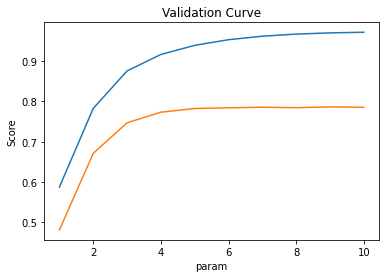

In [16]:
param_range = np.linspace(1, 10, 10, dtype = int )
train_scores, val_scores = validation_curve(
    grid.best_estimator_,
    X_train,
    y_train,
    param_name="rf__max_depth",
    param_range=param_range,
    scoring="r2"
)
print(train_scores)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.title("Validation Curve")
plt.xlabel("param")
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean)
plt.plot(param_range, val_scores_mean)
plt.show()

[[0.90591818 0.9361936  0.9361936  0.9361936  0.9361936 ]
 [0.93726993 0.95801923 0.95801923 0.95801923 0.95801923]
 [0.94978863 0.95751783 0.96604669 0.96604669 0.96604669]
 [0.96100812 0.96460278 0.9540932  0.9540932  0.9540932 ]
 [0.9599176  0.96361045 0.94919729 0.94919729 0.94919729]
 [0.95731032 0.96327204 0.95360162 0.95495517 0.95495517]
 [0.95013577 0.95683927 0.94703497 0.95382611 0.95382611]
 [0.94986053 0.95503882 0.94555695 0.95200456 0.95245739]
 [0.9452354  0.95276607 0.94123821 0.94809558 0.94963181]
 [0.9368135  0.94060228 0.93245909 0.93620928 0.94903365]]


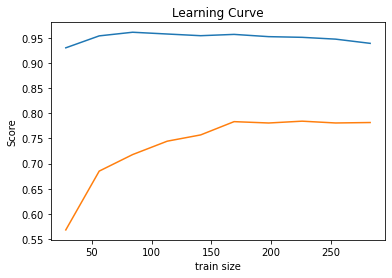

In [17]:
train_sizes, train_scores, val_scores = learning_curve(
    grid.best_estimator_,
    X_train,
    y_train,
    train_sizes=np.linspace(0.1, 1, 10)
)
print(train_scores)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.title("Learning Curve")
plt.xlabel("train size")
plt.ylabel("Score")
plt.plot(train_sizes, train_scores_mean)
plt.plot(train_sizes, val_scores_mean)
plt.show()

# 1.2 Classification model

In [18]:
cancer = datasets.load_breast_cancer()
y = cancer.target
x = cancer.data

df = pd.DataFrame(x, columns = cancer.feature_names)
df['y'] = y

# Adding a random categorica column just for learning
data = ["paris", "barcelona", "kolkata", "new york"]

df['location'] = [random.sample(data,1)[0] for x in range(len(df))]

#adding nulls
for i in range(int(len(df)*0.2)):
    df['mean area'][randrange(len(df))] = np.nan
    df['mean smoothness'][randrange(len(df))] = np.nan
    df['mean compactness'][randrange(len(df))] = np.nan
    
print(sum(df.isnull().sum() * 100 / len(df)))

df.head(10)

53.25131810193322


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80        NaN          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   
5        12.45         15.70           82.57      477.1          0.12780   
6        18.25         19.98          119.60     1040.0          0.09463   
7        13.71         20.83           90.20        NaN              NaN   
8        13.00         21.82           87.50      519.8              NaN   
9        12.46         24.04           83.97      475.9          0.11860   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760         0.30010              0.14710         0.2419   
1           0.07864         0.08690              0.07017         0.1812   
2           0.15990         0.19740              0.12790         0.2069   
3           0.28390         0.24140              0.10520         0.2597   
4           0.13280         0.19800              0.10430         0.1809   
5           0.17000         0.15780              0.08089         0.2087   
6           0.10900         0.11270              0.07400         0.1794   
7           0.16450         0.09366              0.05985         0.2196   
8           0.19320         0.18590              0.09353         0.2350   
9           0.23960         0.22730              0.08543         0.2030   

   mean fractal dimension  ...  worst perimeter  worst area  worst smoothness  \
0                 0.07871  ...           184.60      2019.0            0.1622   
1                 0.05667  ...           158.80      1956.0            0.1238   
2                 0.05999  ...           152.50      1709.0            0.1444   
3                 0.09744  ...            98.87       567.7            0.2098   
4                 0.05883  ...           152.20      1575.0            0.1374   
5                 0.07613  ...           103.40       741.6            0.1791   
6                 0.05742  ...           153.20      1606.0            0.1442   
7                 0.07451  ...           110.60       897.0            0.1654   
8                 0.07389  ...           106.20       739.3            0.1703   
9                 0.08243  ...            97.65       711.4            0.1853   

   worst compactness  worst concavity  worst concave points  worst symmetry  \
0             0.6656           0.7119                0.2654          0.4601   
1             0.1866           0.2416                0.1860          0.2750   
2             0.4245           0.4504                0.2430          0.3613   
3             0.8663           0.6869                0.2575          0.6638   
4             0.2050           0.4000                0.1625          0.2364   
5             0.5249           0.5355                0.1741          0.3985   
6             0.2576           0.3784                0.1932          0.3063   
7             0.3682           0.2678                0.1556          0.3196   
8             0.5401           0.5390                0.2060          0.4378   
9             1.0580           1.1050                0.2210          0.4366   

   worst fractal dimension  y   location  
0                  0.11890  0    kolkata  
1                  0.08902  0   new york  
2                  0.08758  0  barcelona  
3                  0.17300  0    kolkata  
4                  0.07678  0  barcelona  
5                  0.12440  0  barcelona  
6                  0.08368  0  barcelona  
7                  0.11510  0    kolkata  
8                  0.10720  0    kolkata  
9                  0.20750  0    kolkata  

[10 rows x 32 columns]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('y', axis = 1), df['y'], test_size = 0.3, shuffle = True, \
                                                   random_state = 42)

In [20]:
numeric_vars = X_train.select_dtypes(include = np.number).columns.to_list()
categorical_vars = X_train.select_dtypes(exclude = np.number).columns.to_list()
skewed_vars = ['NOX']

print("Numerical cols: ",numeric_vars)
print("categorical cols: ",categorical_vars)

Numerical cols:  ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']
categorical cols:  ['location']


In [21]:
# Pipeline for skewed variables
skew_transformer = PowerTransformer()
skewed_features = []
# Pipeline for numerical variables
numeric_transformer = Pipeline(
    steps=[ 
        ("scaler", StandardScaler()), 
        ("num_imputer",IterativeImputer(max_iter=10, random_state=0))
        #("Pca", PCA())
          ])

# Pipeline for categorical variables
categorical_transformer = Pipeline(
    steps= [ 
        ("categorical_vars", OneHotEncoder(sparse = False, handle_unknown = "ignore")), 
        ("cat_imputer", SimpleImputer(strategy="median"))
           ])

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("skew", skew_transformer, skewed_features),
        ("num", numeric_transformer, numeric_vars),
        ("cat", categorical_transformer, categorical_vars)
    ]
)

# The model
model = Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestClassifier(n_estimators = 200,  max_depth = 8, random_state = 42)),
    
    
])

In [22]:
param  = [
    {'preprocessor__num__num_imputer__max_iter': [10,20], #Can also tune reprocessor params
    'rf__n_estimators': [100, 150, 200, 250, 300],
    'rf__max_features': ['auto'],
    'rf__criterion': ['entropy'],
    'rf__max_depth': [3, 5, 8]}
]

In [23]:
grid = GridSearchCV(estimator = model, param_grid = param, cv = 5, verbose = True, n_jobs = -1 )

In [24]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('skew',
                                                                         PowerTransformer(),
                                                                         []),
                                                                        ('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler()),
                                                                                         ('num_imputer',
                                                                                          IterativeImputer(random_state=0))]),
                                                                         ['mean '
                                                                      

In [25]:
print("Best Score: %0.5f" % grid.best_score_)
print(grid.best_params_)

Best Score: 0.95731
{'preprocessor__num__num_imputer__max_iter': 10, 'rf__criterion': 'entropy', 'rf__max_depth': 5, 'rf__max_features': 'auto', 'rf__n_estimators': 300}


In [26]:
model.set_params(**grid.best_params_)
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('skew', PowerTransformer(),
                                                  []),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('num_imputer',
                                                                   IterativeImputer(random_state=0))]),
                                                  ['mean radius',
                                                   'mean texture',
                                                   'mean perimeter',
                                                   'mean area',
                                                   'mean smoothness',
                                                   'mean compactness',
                     

In [27]:
model.score(X_test,y_test)

0.9707602339181286

In [28]:
model.named_steps["rf"].feature_importances_

array([0.03174053, 0.02290328, 0.04187776, 0.03364521, 0.00763703,
       0.00877726, 0.06737645, 0.11737477, 0.00370529, 0.00475436,
       0.01989301, 0.00482829, 0.01202435, 0.03149322, 0.00450154,
       0.0058782 , 0.0084882 , 0.00741156, 0.0056499 , 0.00535274,
       0.09712229, 0.0276996 , 0.12989452, 0.08223398, 0.01320885,
       0.01667159, 0.04983973, 0.11646557, 0.01404469, 0.00519707,
       0.00089175, 0.00028189, 0.00040691, 0.00072862])

In [29]:
important_features = pd.Series(data=model.named_steps["rf"].feature_importances_,index=np.concatenate((np.asarray(numeric_vars), np.asarray(model['preprocessor'].transformers_[2][1]['categorical_vars'].get_feature_names(categorical_vars))) ))
important_features.sort_values(ascending=False,inplace=True)
important_features

worst perimeter            0.129895
mean concave points        0.117375
worst concave points       0.116466
worst radius               0.097122
worst area                 0.082234
mean concavity             0.067376
worst concavity            0.049840
mean perimeter             0.041878
mean area                  0.033645
mean radius                0.031741
area error                 0.031493
worst texture              0.027700
mean texture               0.022903
radius error               0.019893
worst compactness          0.016672
worst symmetry             0.014045
worst smoothness           0.013209
perimeter error            0.012024
mean compactness           0.008777
concavity error            0.008488
mean smoothness            0.007637
concave points error       0.007412
compactness error          0.005878
symmetry error             0.005650
fractal dimension error    0.005353
worst fractal dimension    0.005197
texture error              0.004828
mean fractal dimension     0

In [30]:
pd.DataFrame(model.named_steps["preprocessor"].transform(X_train), columns = np.concatenate((np.asarray(numeric_vars), np.asarray(model['preprocessor'].transformers_[2][1]['categorical_vars'].get_feature_names(categorical_vars))) )).head()

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0    -0.123490     -0.296801       -0.170507  -0.255939        -1.157967   
1    -0.228268     -0.657951       -0.253775  -0.299098        -1.754426   
2     0.145534     -1.230564        0.245833  -0.063176         0.871031   
3    -0.358532     -0.672207       -0.400937  -0.441925        -1.038174   
4    -0.157472      0.967224       -0.208843  -0.287931        -0.221188   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0         -0.772017       -0.762312            -0.933241      -1.229949   
1         -0.557594       -0.091985            -0.542684      -1.419985   
2          1.507115        0.732320             0.386583       1.054201   
3         -0.964100       -0.634704            -0.654992       0.096572   
4         -0.632733       -0.750349            -0.637469      -0.518248   

   mean fractal dimension  ...  worst smoothness  worst compactness  \
0               -0.948166  ...         -1.507424          -0.449260   
1               -0.612491  ...         -1.273017           0.027042   
2                1.574228  ...         -0.024877           0.770802   
3               -0.827986  ...         -0.959895          -0.663496   
4               -0.642882  ...         -0.442374          -0.656085   

   worst concavity  worst concave points  worst symmetry  \
0        -0.572239             -0.840822       -0.856362   
1         0.318045             -0.377067       -1.341582   
2         0.272612             -0.047627       -0.089971   
3        -0.470142             -0.493515        0.226547   
4        -0.835138             -0.659802       -0.387208   

   worst fractal dimension  location_barcelona  location_kolkata  \
0                -0.765748                 0.0               0.0   
1                -0.414807                 1.0               0.0   
2                 0.488264                 0.0               0.0   
3                -0.802899                 0.0               0.0   
4                -0.800613                 0.0               0.0   

   location_new york  location_paris  
0                0.0             1.0  
1                0.0             0.0  
2                1.0             0.0  
3                1.0             0.0  
4                0.0             1.0  

[5 rows x 34 columns]

[[0.74485875 0.71800177 0.71800177 0.73283082 0.69172269]
 [0.82542967 0.85228664 0.83885816 0.86641541 0.81235294]
 [0.93285757 0.93285757 0.91942908 0.93320771 0.89277311]
 [0.94628605 0.97314303 0.95971454 0.98664154 0.95978992]
 [0.98657151 0.98657151 0.97314303 1.         0.97319328]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]]


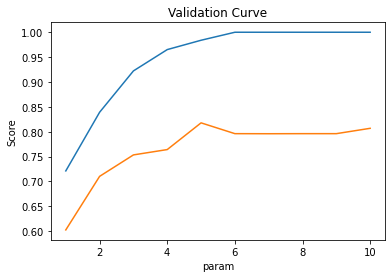

In [31]:
param_range = np.linspace(1, 10, 10, dtype = int )
train_scores, val_scores = validation_curve(
    grid.best_estimator_,
    X_train,
    y_train,
    param_name="rf__max_depth",
    param_range=param_range,
    scoring="r2"
)
print(train_scores)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.title("Validation Curve")
plt.xlabel("param")
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean)
plt.plot(param_range, val_scores_mean)
plt.show()

[[1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [0.9954955  1.         0.9954955  1.         1.        ]
 [0.99606299 0.99606299 0.99606299 1.         1.        ]
 [0.9965035  0.9965035  0.99300699 1.         1.        ]
 [0.99685535 0.99685535 0.99371069 1.         0.99371069]]


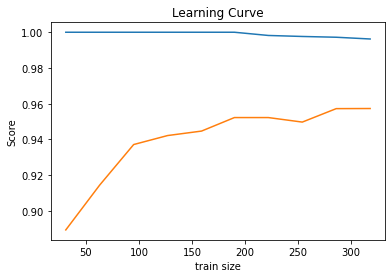

In [32]:
train_sizes, train_scores, val_scores = learning_curve(
    grid.best_estimator_,
    X_train,
    y_train,
    train_sizes=np.linspace(0.1, 1, 10)
)
print(train_scores)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.title("Learning Curve")
plt.xlabel("train size")
plt.ylabel("Score")
plt.plot(train_sizes, train_scores_mean)
plt.plot(train_sizes, val_scores_mean)
plt.show()

In [33]:
y_pred = model.predict(X_test)

In [34]:
y_prob = model.predict_proba(X_test)

In [35]:
y_train_prob = model.predict_proba(X_train)[:, 1]

In [36]:
print(roc_auc_score(y_test, y_prob[:,1]))

0.9970605526161082


No Skill: ROC AUC=0.500
RF: ROC AUC=0.997


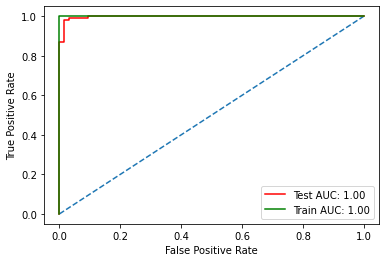

In [37]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# calculate scores
no_skill_auc = roc_auc_score(y_test, ns_probs)
xgb_train_auc = roc_auc_score(y_train, y_train_prob)
xgb_auc = roc_auc_score(y_test, y_prob[:, 1])

# summarize scores
print('No Skill: ROC AUC=%.3f' % (no_skill_auc))
print('RF: ROC AUC=%.3f' % (xgb_auc))

# calculate roc curve
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--')
pyplot.plot(fpr, tpr, linestyle='-', color = 'red', label=('Test AUC: %0.2f' % xgb_auc) )
pyplot.plot(fpr_train, tpr_train, linestyle='-', color = 'green', label=('Train AUC: %0.2f' % xgb_train_auc))
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

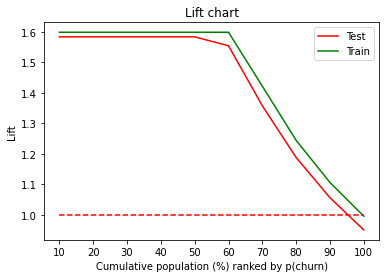

In [38]:
def compute_lift_chart(target_values, prob):
    pchurn    = pd.DataFrame({'Observed': target_values, 'p_churn': prob})
    sorted_df = pchurn.sort_values(by=['p_churn'], ascending=False)
    
    lift_chart         = np.zeros(10)
    cum_rel_lift_chart = np.zeros(10)
    
    dec_size       = int(np.ceil(sorted_df.shape[0]/10))
    overall_ratio  = sorted_df.Observed.sum()/sorted_df.shape[0]
    for i in range(0,10):
        lift_chart[i]         = 100*sorted_df.Observed.iloc[i*dec_size:(i+1)*dec_size].sum()/dec_size
        cum_rel_lift_chart[i] = sorted_df.Observed.iloc[:(i+1)*dec_size].sum()/((i+1)*dec_size)/overall_ratio
    
    return (np.arange(10,110,10), lift_chart, cum_rel_lift_chart)

x, _, lift_test  = compute_lift_chart(y_test, y_prob[:, 1])
x_train, _, lift_train = compute_lift_chart(y_train, y_train_prob)
plt.plot(x, lift_test, color = 'red', label='Test')
plt.plot(x_train, lift_train, color = 'green', label='Train')
plt.plot([10,100],[1,1],'r--')
plt.xlabel('Cumulative population (%) ranked by p(churn)')
plt.xticks(np.arange(10,110,10))
plt.ylabel('Lift')
plt.title('Lift chart')
plt.legend(loc=1)
plt.show()

In [39]:
from sklearn.metrics import precision_recall_curve
y_prob = model.predict_proba(X_test)

p, r, thresholds = precision_recall_curve(y_test,y_prob[:,1])

In [40]:
def adjusted_classes(y_prob, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_prob]

from sklearn.metrics import confusion_matrix
def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_prob[:,1], t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

     pred_neg  pred_pos
neg        57         6
pos         0       108


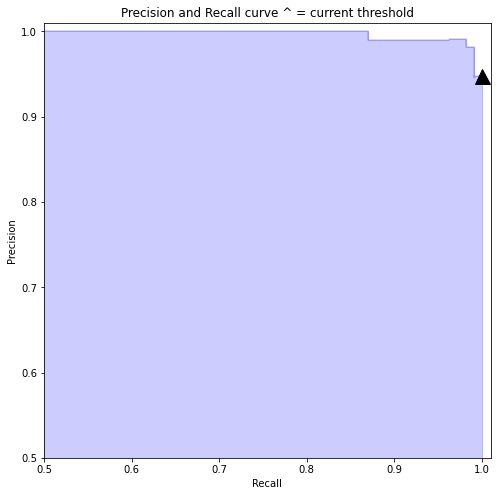

In [41]:
precision_recall_threshold(p, r, thresholds, 0.30)

In [42]:
thresholds

array([0.32409464, 0.36720133, 0.46171503, 0.54285313, 0.58567009,
       0.60471401, 0.61486266, 0.66469776, 0.67483457, 0.67720395,
       0.70943681, 0.72748758, 0.73017155, 0.73828619, 0.74397884,
       0.74672918, 0.77320722, 0.7840113 , 0.78670975, 0.79875927,
       0.81044677, 0.84226394, 0.87359254, 0.87914695, 0.88558516,
       0.90113827, 0.90347898, 0.91219455, 0.91973786, 0.93248273,
       0.93470602, 0.93605724, 0.93896394, 0.9410203 , 0.94105167,
       0.94290873, 0.9446187 , 0.94700749, 0.94860292, 0.95094152,
       0.95592978, 0.95918116, 0.95978148, 0.96168518, 0.9624735 ,
       0.96303844, 0.96309684, 0.96454962, 0.96474856, 0.96489795,
       0.96808559, 0.96954683, 0.96960261, 0.97032785, 0.97114969,
       0.9726762 , 0.97270206, 0.97633071, 0.97707287, 0.9780216 ,
       0.9799197 , 0.9802865 , 0.98130801, 0.98151472, 0.98252352,
       0.98290558, 0.98547427, 0.98575343, 0.98653457, 0.98700171,
       0.98784893, 0.98919313, 0.98961966, 0.98971461, 0.99026

Many different ways to choose threshold, here its important to have no false positives

But you can try maximise the F score ect.

Best Threshold=0.604714, F-Score=0.986
     pred_neg  pred_pos
neg        60         3
pos         1       107


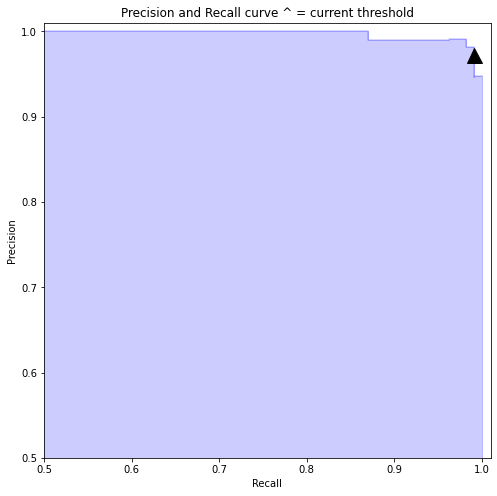

In [43]:
fscore = (2 * p  * r ) / (p  + r )
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
precision_recall_threshold(p, r, thresholds, 0.566667)

# 2 Other pipeline with feature selection ect.

Load data in

In [2]:
cancer = datasets.load_breast_cancer()
y = cancer.target
x = cancer.data

df = pd.DataFrame(x, columns = cancer.feature_names)
df['y'] = y

# Adding a random categorica column just for learning
data = ["paris", "barcelona", "kolkata", "new york"]

df['location'] = [random.sample(data,1)[0] for x in range(len(df))]

#adding nulls
for i in range(int(len(df)*0.2)):
    df['mean area'][randrange(len(df))] = np.nan
    df['mean smoothness'][randrange(len(df))] = np.nan
    df['mean compactness'][randrange(len(df))] = np.nan
    
print(sum(df.isnull().sum() * 100 / len(df)))

df.head(10)

52.72407732864676


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80        NaN          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00        NaN          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   
5        12.45         15.70           82.57      477.1          0.12780   
6        18.25         19.98          119.60     1040.0          0.09463   
7        13.71         20.83           90.20      577.9              NaN   
8        13.00         21.82           87.50      519.8          0.12730   
9        12.46         24.04           83.97      475.9          0.11860   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0               NaN         0.30010              0.14710         0.2419   
1           0.07864         0.08690              0.07017         0.1812   
2           0.15990         0.19740              0.12790         0.2069   
3               NaN         0.24140              0.10520         0.2597   
4           0.13280         0.19800              0.10430         0.1809   
5           0.17000         0.15780              0.08089         0.2087   
6           0.10900         0.11270              0.07400         0.1794   
7           0.16450         0.09366              0.05985         0.2196   
8           0.19320         0.18590              0.09353         0.2350   
9           0.23960         0.22730              0.08543         0.2030   

   mean fractal dimension  ...  worst perimeter  worst area  worst smoothness  \
0                 0.07871  ...           184.60      2019.0            0.1622   
1                 0.05667  ...           158.80      1956.0            0.1238   
2                 0.05999  ...           152.50      1709.0            0.1444   
3                 0.09744  ...            98.87       567.7            0.2098   
4                 0.05883  ...           152.20      1575.0            0.1374   
5                 0.07613  ...           103.40       741.6            0.1791   
6                 0.05742  ...           153.20      1606.0            0.1442   
7                 0.07451  ...           110.60       897.0            0.1654   
8                 0.07389  ...           106.20       739.3            0.1703   
9                 0.08243  ...            97.65       711.4            0.1853   

   worst compactness  worst concavity  worst concave points  worst symmetry  \
0             0.6656           0.7119                0.2654          0.4601   
1             0.1866           0.2416                0.1860          0.2750   
2             0.4245           0.4504                0.2430          0.3613   
3             0.8663           0.6869                0.2575          0.6638   
4             0.2050           0.4000                0.1625          0.2364   
5             0.5249           0.5355                0.1741          0.3985   
6             0.2576           0.3784                0.1932          0.3063   
7             0.3682           0.2678                0.1556          0.3196   
8             0.5401           0.5390                0.2060          0.4378   
9             1.0580           1.1050                0.2210          0.4366   

   worst fractal dimension  y   location  
0                  0.11890  0    kolkata  
1                  0.08902  0  barcelona  
2                  0.08758  0      paris  
3                  0.17300  0    kolkata  
4                  0.07678  0    kolkata  
5                  0.12440  0  barcelona  
6                  0.08368  0    kolkata  
7                  0.11510  0   new york  
8                  0.10720  0   new york  
9                  0.20750  0  barcelona  

[10 rows x 32 columns]

In [3]:
numeric_vars = df.select_dtypes(include = np.number).columns.to_list()
categorical_vars = df.select_dtypes(exclude = np.number).columns.to_list()

print("Numerical cols: ",numeric_vars)
print("categorical cols: ",categorical_vars)

Numerical cols:  ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension', 'y']
categorical cols:  ['location']


#### Feature selection

Methods:

***Bold*** = Will show below

- Data Cleaning:
    - Dropping high % missing values
    - Imputing others (many methods)


- Feature engineering:
    - Changing dates to numerical values
    - Creating flags
    - aggregations
    - poly features
    - Encoding categorical data

- Removing features with:
    - ***low variance***
    - ***high correlations (not with target): Network X Package***
    - Single valued features
    - Priro knowldege useless fetaures

- Transforming data:
    - ***Power transformations to change distribution***
        - linear and non linera transformations
    - Reducing cardinality
    - ***Under and over sampling***
    
- Smarter methods:
    - ***Selecting features with feature importance (can use means from cv)***
        - Sequential Feature Selection
        - Tree-based feature selection (feature importance)
        - Recursive feature elimination
    

#### After training

Methods:

- ***Probability calibration***

- ***Permutation test score (sees if your model is good by chance)***

- ***Partial Dependence Plots (sees what affect each feature has on prediciting the target***


<br>

### low variance Feature reduction

In [4]:
print("shape of df before feature reduction: ", df.shape)

from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(6e-05)
x = selector.fit_transform(df.drop(categorical_vars+['y'],axis = 1))
names_in = selector.feature_names_in_
numeric_vars = selector.get_feature_names_out()
dropped = list(set(names_in) - set(numeric_vars))
print("Features to drop: ",dropped)
print("Number of features to drop: ", len(dropped))
df.drop(dropped, axis = 1, inplace = True)



shape of df before feature reduction:  (569, 32)
Features to drop:  ['concave points error', 'mean fractal dimension', 'fractal dimension error', 'smoothness error']
Number of features to drop:  4


# high correlations (not with target): Network X Package

In [5]:
import networkx
from tqdm import tqdm 
def MIS(df, numerical_features, dropped, corr_threshold):
    """
    This is a function designed for the feature_engineering_pipeline wrapper 
    function. This function utilises the networkX package. It adds highly 
    correlated pairs of features to a graph, after the graph is complete it 
    calculates the maximal independent set of the graph. Lastly from the list of
    highly correlated features, we drop all features that are not present in the
    maximal independent set.
    
    Inputs: 
    
        df (pandas.core.frame.DataFrame) - Dataframe containing CDR or 
                                           propensity mobile mart data.
        
        numerical_features (List) - List of numerical features in df.                          
        
        dropped (List) - List of features that were dropped.
        
        corr_threshold (Float) - Correlation coefficient threshold for dropping
                                 features.
                                 
        train (Boolean) - Assign True if df is training data, else False for
                          testing data.
        
    Returns: 
    
        df (pandas.core.frame.DataFrame) - Ammended dataframe.
        
        numerical_features (List) - List of ammended numerical features in df.
        
        dropped (List) - Ammended list of features that were dropped.
    """
    

    print("Step 5 of 11: Obtaining the maximal independent set of "+\
          "features.")
    #Correlation matix
    corrmat = df[numerical_features].corr()
    G = networkx.Graph()
    #looping through each pair
    for i in tqdm(range(0, corrmat.shape[0]-1)):
        for j in range(i+1, corrmat.shape[1]):
            #checking if they meet the correlation threshold
            if (corrmat.iloc[i,j] > corr_threshold):
                #adding them as nodes to the groph
                G.add_edges_from([ (corrmat.index[i], corrmat.columns[j]) ])
    # Fidning the maximal independent set
    mis = networkx.maximal_independent_set(G, seed=1234)
    #dropping the highly correlated features that are not in the MIS
    numerical_features = list( set(numerical_features) - (set(G.nodes)-\
                                                          set(mis))) 
    dropped = dropped + list(set(G.nodes)-set(mis))
    df.drop(list(set(G.nodes)-set(mis)),axis=1, inplace=True)   
    print("     Number of dropped features using MIS: ", len(set(G.nodes)-\
                                                             set(mis)))
    print("")
    
    return df, numerical_features, dropped 

In [6]:
df, numeric_vars, dropped = MIS(df, numeric_vars, dropped, corr_threshold = 0.9)

Step 5 of 11: Obtaining the maximal independent set of features.


100%|██████████| 25/25 [00:00<00:00, 2743.60it/s]

     Number of dropped features using MIS:  9



In [7]:
df.shape

(569, 19)

Power transformations to change distribution

In [8]:
import seaborn as sns
#sns.pairplot(df)
#from this found non gaussian features

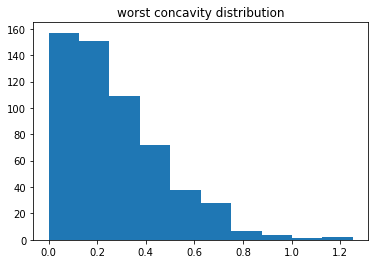

In [9]:
bad_dist = [
'worst concavity']

for column in bad_dist:
    plt.title(column + " distribution")
    plt.hist(df[column])
    plt.show
    

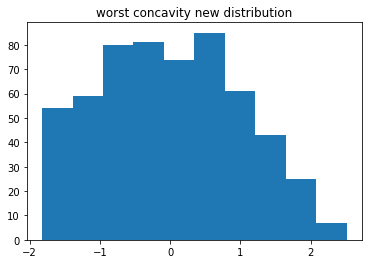

In [10]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
df['worst concavity'] = pt.fit_transform(df[['worst concavity']])

for column in bad_dist:
    plt.title(column + " new distribution")
    plt.hist(df[column])
    plt.show

#### Sampling

In [11]:
df['y'].value_counts()

1    357
0    212
Name: y, dtype: int64

In [12]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(df.drop('y', axis = 1), df['y'])


In [13]:
y_over.value_counts()

0    357
1    357
Name: y, dtype: int64

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('y', axis = 1), df['y'], test_size = 0.3, shuffle = True, \
                                                   random_state = 42)

#### Feature importance

In [15]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.model_selection import cross_validate, KFold
from xgboost import XGBClassifier

In [16]:
# Pipeline for skewed variables
skew_transformer = PowerTransformer()
# Pipeline for numerical variables
numeric_transformer = Pipeline(
    steps=[ 
        ("scaler", StandardScaler()), 
        ("num_imputer",IterativeImputer(max_iter=10, random_state=0))
        #("Pca", PCA())
          ])

# Pipeline for categorical variables
categorical_transformer = Pipeline(
    steps= [ 
        ("categorical_vars", OneHotEncoder(sparse = False, handle_unknown = "ignore")), 
        ("cat_imputer", SimpleImputer(strategy="median"))
           ])

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_vars),
        ("cat", categorical_transformer, categorical_vars)
    ]
)

# The model
model = Pipeline([
    ("preprocessor", preprocessor),
    ("xg", XGBClassifier(max_depth=4, importance_type='gain', use_label_encoder=False)),
    
    
])

In [17]:
xgb = pd.DataFrame(cross_validate(model, X_train, y_train, cv=5, return_train_score=True, return_estimator=True))
xgb

[11:18:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:18:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:18:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:18:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

fit_time  score_time                                          estimator  \
0  0.472456    0.011922  (ColumnTransformer(transformers=[('num',\n    ...   
1  0.500778    0.012448  (ColumnTransformer(transformers=[('num',\n    ...   
2  0.495256    0.012200  (ColumnTransformer(transformers=[('num',\n    ...   
3  0.448256    0.011371  (ColumnTransformer(transformers=[('num',\n    ...   
4  0.469041    0.011333  (ColumnTransformer(transformers=[('num',\n    ...   

   test_score  train_score  
0    0.962500          1.0  
1    0.937500          1.0  
2    1.000000          1.0  
3    0.949367          1.0  
4    0.974684          1.0

In [18]:
categorical_vars = list(xgb['estimator'][0][0].transformers_[-1][1]['categorical_vars'].get_feature_names(categorical_vars))
variables = np.concatenate((np.asarray(numeric_vars), np.asarray(categorical_vars)))

In [19]:
xgb_weights = pd.DataFrame({f'weight_{0}':xgb['estimator'][0][-1].feature_importances_}
                           , index=variables)

for i in range(1, len(xgb)):
    xgb_weights = xgb_weights.merge(
        pd.DataFrame({f'weight_{i}':xgb['estimator'][i][-1].feature_importances_}
                     , index=variables)
    
        , how='outer', left_index=True, right_index=True)
cols = xgb_weights.columns
xgb_weights['mean'] = xgb_weights[cols].mean(axis=1)
xgb_weights.sort_values(by='mean',ascending=False,inplace=True)
xgb_weights.head(10)

weight_0  weight_1  weight_2  weight_3  weight_4  \
worst concave points  0.634009  0.651022  0.545507  0.568800  0.566909   
mean area             0.112509  0.078244  0.090188  0.091203  0.106608   
worst concavity       0.057507  0.079369  0.074581  0.046984  0.036328   
concavity error       0.036788  0.014883  0.004524  0.060438  0.080177   
worst texture         0.029602  0.041776  0.036197  0.023998  0.030995   
mean compactness      0.004158  0.040034  0.071453  0.000000  0.010977   
worst smoothness      0.012890  0.017426  0.016943  0.026044  0.020810   
mean concavity        0.006793  0.013163  0.030404  0.014219  0.024431   
perimeter error       0.016700  0.004350  0.018816  0.019683  0.013409   
mean smoothness       0.007004  0.004601  0.031636  0.010283  0.010381   

                          mean  
worst concave points  0.593250  
mean area             0.095750  
worst concavity       0.058954  
concavity error       0.039362  
worst texture         0.032514  
mean compactness      0.025324  
worst smoothness      0.018823  
mean concavity        0.017802  
perimeter error       0.014592  
mean smoothness       0.012781

In [20]:
#keep 18 most important features
keep = xgb_weights.sort_values(by=['mean'], ascending=False).index[:14]
keep

Index(['worst concave points', 'mean area', 'worst concavity',
       'concavity error', 'worst texture', 'mean compactness',
       'worst smoothness', 'mean concavity', 'perimeter error',
       'mean smoothness', 'mean symmetry', 'worst compactness',
       'compactness error', 'location_kolkata'],
      dtype='object')

In [22]:
to_drop = []

# Here we only want to drop numerical features as the categorical ones are encoded but there not encoded in df.
for column in numeric_vars:
    if column not in keep:
        to_drop.append(column)
        
        
dropped = dropped + to_drop            
df.drop(to_drop,axis = 1,inplace = True)

numeric_vars = df.select_dtypes(include = np.number).columns.to_list()
categorical_vars = df.select_dtypes(exclude = np.number).columns.to_list()

print("Numerical cols: ",numeric_vars)
print("categorical cols: ",categorical_vars)

Numerical cols:  ['mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean symmetry', 'perimeter error', 'compactness error', 'concavity error', 'worst texture', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'y']
categorical cols:  ['location']


#### Data entering the piepline for modelling

In [75]:
# Pipeline for skewed variables
skew_transformer = PowerTransformer()
skewed_features = []
# Pipeline for numerical variables
numeric_transformer = Pipeline(
    steps=[ 
        ("scaler", StandardScaler()), 
        ("num_imputer",IterativeImputer(max_iter=10, random_state=0))
        #("Pca", PCA())
          ])

# Pipeline for categorical variables
categorical_transformer = Pipeline(
    steps= [ 
        ("categorical_vars", OneHotEncoder(sparse = False, handle_unknown = "ignore")), 
        ("cat_imputer", SimpleImputer(strategy="median"))
           ])

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("skew", skew_transformer, skewed_features),
        ("num", numeric_transformer, numeric_vars),
        ("cat", categorical_transformer, categorical_vars)
    ]
)

# The model
model = Pipeline([
    ("preprocessor", preprocessor),
    ("rf", RandomForestClassifier(n_estimators = 200,  max_depth = 8, random_state = 42)),  
])

In [76]:
param  = [
    {'preprocessor__num__num_imputer__max_iter': [10,20], #Can also tune reprocessor params
    'rf__n_estimators': [100, 150, 200, 250, 300],
    'rf__max_features': ['auto'],
    'rf__criterion': ['entropy'],
    'rf__max_depth': [3, 5, 8]}
]

In [77]:
grid = GridSearchCV(estimator = model, param_grid = param, cv = 5, verbose = True, n_jobs = -1 )

In [78]:
grid.fit(X_train, y_train);

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [79]:
print("Best Score: %0.5f" % grid.best_score_)
print(grid.best_params_)

Best Score: 0.95475
{'preprocessor__num__num_imputer__max_iter': 10, 'rf__criterion': 'entropy', 'rf__max_depth': 5, 'rf__max_features': 'auto', 'rf__n_estimators': 100}


In [80]:
model.set_params(**grid.best_params_)
model.fit(X_train, y_train);

In [81]:
model.score(X_test,y_test)

0.9707602339181286

In [82]:
important_features = pd.Series(data=model.named_steps["rf"].feature_importances_,index=np.concatenate((np.asarray(numeric_vars), np.asarray(model['preprocessor'].transformers_[2][1]['categorical_vars'].get_feature_names(categorical_vars))) ))
important_features.sort_values(ascending=False,inplace=True)
important_features

worst concave points       0.150579
worst perimeter            0.138032
worst area                 0.096312
mean concave points        0.094093
worst radius               0.091385
mean concavity             0.065103
worst concavity            0.044142
mean radius                0.039567
area error                 0.033645
mean perimeter             0.029802
worst texture              0.028143
mean texture               0.024551
mean area                  0.021942
radius error               0.017311
worst smoothness           0.015320
worst symmetry             0.013648
worst compactness          0.010926
mean compactness           0.008745
concave points error       0.008613
mean smoothness            0.008338
perimeter error            0.008296
concavity error            0.007922
symmetry error             0.007059
compactness error          0.006817
mean fractal dimension     0.005776
texture error              0.005608
fractal dimension error    0.005151
worst fractal dimension    0

In [83]:
pd.DataFrame(model.named_steps["preprocessor"].transform(X_train), columns = np.concatenate((np.asarray(numeric_vars), np.asarray(model['preprocessor'].transformers_[2][1]['categorical_vars'].get_feature_names(categorical_vars))) )).head()

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0    -0.123490     -0.296801       -0.170507  -0.214252        -1.214632   
1    -0.228268     -0.657951       -0.253775  -0.300931        -1.822346   
2     0.145534     -1.230564        0.245833  -0.018606         0.519810   
3    -0.358532     -0.672207       -0.400937  -0.403019        -1.216831   
4    -0.157472      0.967224       -0.208843  -0.242345        -0.260175   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0         -0.809608       -0.762312            -0.933241      -1.229949   
1         -0.601288       -0.091985            -0.542684      -1.419985   
2          1.500889        0.732320             0.386583       1.054201   
3         -0.974479       -0.634704            -0.654992       0.096572   
4         -0.711397       -0.750349            -0.637469      -0.518248   

   mean fractal dimension  ...  worst smoothness  worst compactness  \
0               -0.948166  ...         -1.507424          -0.449260   
1               -0.612491  ...         -1.273017           0.027042   
2                1.574228  ...         -0.024877           0.770802   
3               -0.827986  ...         -0.959895          -0.663496   
4               -0.642882  ...         -0.442374          -0.656085   

   worst concavity  worst concave points  worst symmetry  \
0        -0.572239             -0.840822       -0.856362   
1         0.318045             -0.377067       -1.341582   
2         0.272612             -0.047627       -0.089971   
3        -0.470142             -0.493515        0.226547   
4        -0.835138             -0.659802       -0.387208   

   worst fractal dimension  location_barcelona  location_kolkata  \
0                -0.765748                 1.0               0.0   
1                -0.414807                 0.0               1.0   
2                 0.488264                 0.0               1.0   
3                -0.802899                 0.0               0.0   
4                -0.800613                 1.0               0.0   

   location_new york  location_paris  
0                0.0             0.0  
1                0.0             0.0  
2                0.0             0.0  
3                0.0             1.0  
4                0.0             0.0  

[5 rows x 34 columns]

[[0.71800177 0.74485875 0.74485875 0.71947236 0.67831933]
 [0.82542967 0.86571513 0.7985727  0.86641541 0.8257563 ]
 [0.93285757 0.94628605 0.93285757 0.93320771 0.89277311]
 [0.95971454 0.97314303 0.95971454 0.98664154 0.95978992]
 [0.98657151 0.98657151 0.97314303 1.         0.97319328]
 [1.         1.         1.         1.         0.98659664]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]]


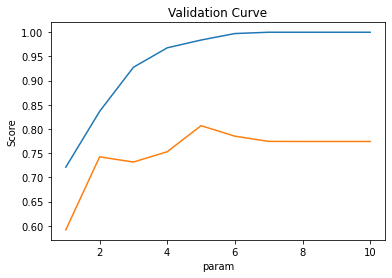

In [84]:
param_range = np.linspace(1, 10, 10, dtype = int )
train_scores, val_scores = validation_curve(
    grid.best_estimator_,
    X_train,
    y_train,
    param_name="rf__max_depth",
    param_range=param_range,
    scoring="r2"
)
print(train_scores)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.title("Validation Curve")
plt.xlabel("param")
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean)
plt.plot(param_range, val_scores_mean)
plt.show()

[[1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [0.9954955  1.         0.9954955  1.         1.        ]
 [0.99606299 0.99606299 0.99606299 1.         1.        ]
 [0.9965035  0.9965035  0.99300699 1.         1.        ]
 [0.99685535 0.99685535 0.99371069 1.         0.99685535]]


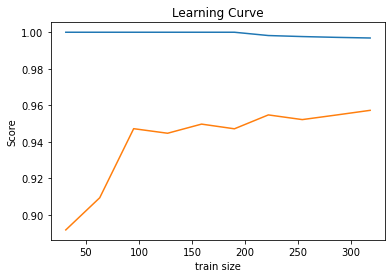

In [85]:
train_sizes, train_scores, val_scores = learning_curve(
    grid.best_estimator_,
    X_train,
    y_train,
    train_sizes=np.linspace(0.1, 1, 10)
)
print(train_scores)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.title("Learning Curve")
plt.xlabel("train size")
plt.ylabel("Score")
plt.plot(train_sizes, train_scores_mean)
plt.plot(train_sizes, val_scores_mean)
plt.show()

In [86]:
y_pred = model.predict(X_test)

In [87]:
y_prob = model.predict_proba(X_test)

In [88]:
y_train_prob = model.predict_proba(X_train)[:, 1]

In [89]:
print(roc_auc_score(y_test, y_prob[:,1]))

0.9972075249853029


No Skill: ROC AUC=0.500
RF: ROC AUC=0.997


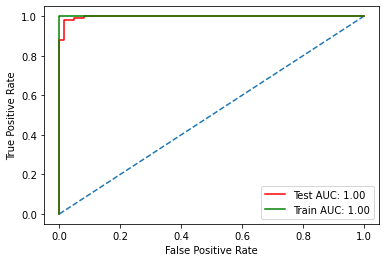

In [90]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# calculate scores
no_skill_auc = roc_auc_score(y_test, ns_probs)
xgb_train_auc = roc_auc_score(y_train, y_train_prob)
xgb_auc = roc_auc_score(y_test, y_prob[:, 1])

# summarize scores
print('No Skill: ROC AUC=%.3f' % (no_skill_auc))
print('RF: ROC AUC=%.3f' % (xgb_auc))

# calculate roc curve
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--')
pyplot.plot(fpr, tpr, linestyle='-', color = 'red', label=('Test AUC: %0.2f' % xgb_auc) )
pyplot.plot(fpr_train, tpr_train, linestyle='-', color = 'green', label=('Train AUC: %0.2f' % xgb_train_auc))
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

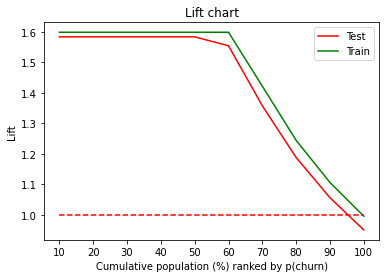

In [91]:
def compute_lift_chart(target_values, prob):
    pchurn    = pd.DataFrame({'Observed': target_values, 'p_churn': prob})
    sorted_df = pchurn.sort_values(by=['p_churn'], ascending=False)
    
    lift_chart         = np.zeros(10)
    cum_rel_lift_chart = np.zeros(10)
    
    dec_size       = int(np.ceil(sorted_df.shape[0]/10))
    overall_ratio  = sorted_df.Observed.sum()/sorted_df.shape[0]
    for i in range(0,10):
        lift_chart[i]         = 100*sorted_df.Observed.iloc[i*dec_size:(i+1)*dec_size].sum()/dec_size
        cum_rel_lift_chart[i] = sorted_df.Observed.iloc[:(i+1)*dec_size].sum()/((i+1)*dec_size)/overall_ratio
    
    return (np.arange(10,110,10), lift_chart, cum_rel_lift_chart)

x, _, lift_test  = compute_lift_chart(y_test, y_prob[:, 1])
x_train, _, lift_train = compute_lift_chart(y_train, y_train_prob)
plt.plot(x, lift_test, color = 'red', label='Test')
plt.plot(x_train, lift_train, color = 'green', label='Train')
plt.plot([10,100],[1,1],'r--')
plt.xlabel('Cumulative population (%) ranked by p(churn)')
plt.xticks(np.arange(10,110,10))
plt.ylabel('Lift')
plt.title('Lift chart')
plt.legend(loc=1)
plt.show()

In [92]:
from sklearn.metrics import precision_recall_curve
y_prob = model.predict_proba(X_test)

p, r, thresholds = precision_recall_curve(y_test,y_prob[:,1])

In [93]:
def adjusted_classes(y_prob, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_prob]

from sklearn.metrics import confusion_matrix
def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_prob[:,1], t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

     pred_neg  pred_pos
neg        58         5
pos         1       107


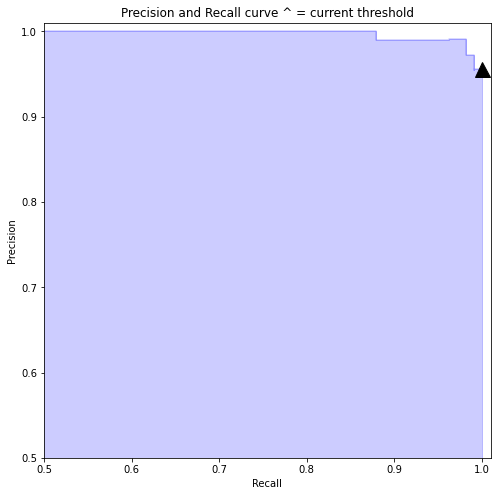

In [94]:
precision_recall_threshold(p, r, thresholds, 0.30)